<a href="https://colab.research.google.com/github/jithsg/2-Pipeline/blob/main/Sensitivity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Detected 20 ICs


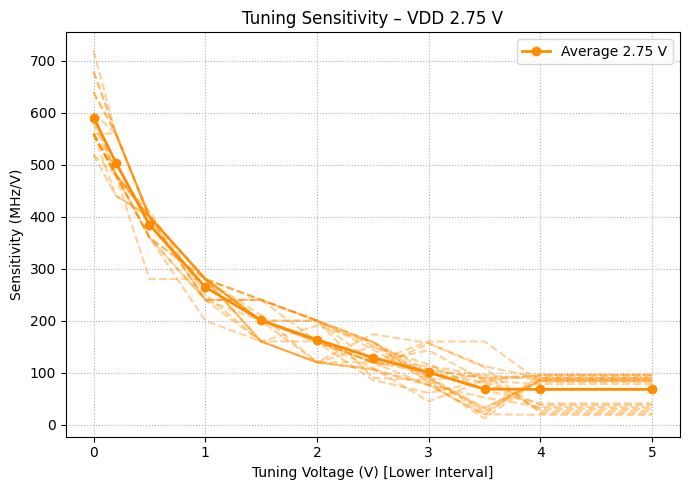

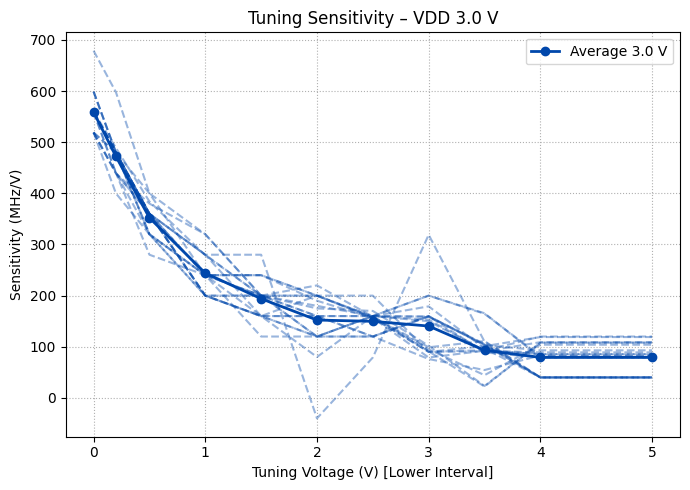

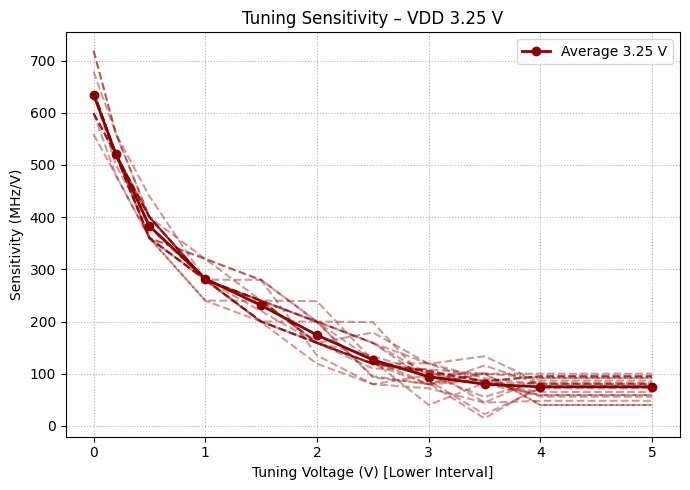

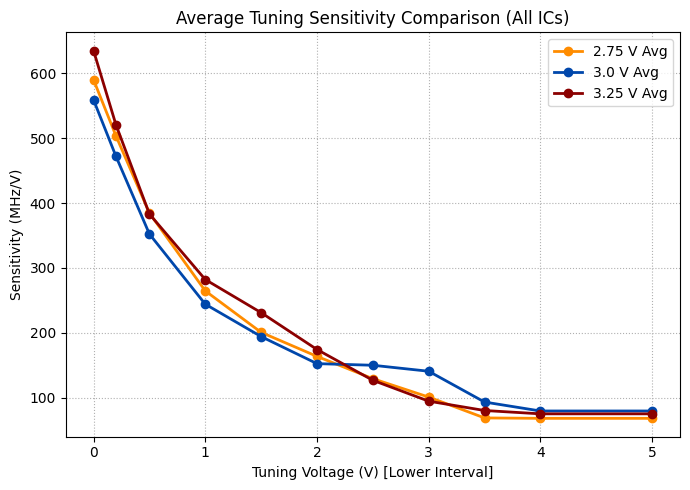

In [7]:
%matplotlib inline
import pandas as pd, numpy as np, matplotlib.pyplot as plt

# -----------------------------
# Load Excel data
# -----------------------------
EXCEL_PATH = "Raw_data_A1.xlsx"
SHEET_NAME = "Vdd_variation"
raw = pd.read_excel(EXCEL_PATH, sheet_name=SHEET_NAME, header=None)

# -----------------------------
# Detect IC blocks
# -----------------------------
def find_ic_blocks(df):
    starts = []
    for r in range(len(df)):
        v = df.iloc[r, 0]
        if isinstance(v, str) and v.strip().upper().startswith("IC") and r + 4 < len(df):
            if ("Vtune" in str(df.iloc[r+1, 0]) and
                "2.75" in str(df.iloc[r+2, 0]) and
                str(df.iloc[r+3, 0]).strip() == "3V" and
                "3.25" in str(df.iloc[r+4, 0])):
                starts.append(r)
    return starts

IC_STARTS = find_ic_blocks(raw)
print(f"Detected {len(IC_STARTS)} ICs")

# -----------------------------
# Extract vtune + freq data
# -----------------------------
def extract_ic_series(df, r, vt_max=6.0):
    ic_name = str(df.iloc[r, 0]).strip()
    vt   = pd.to_numeric(df.iloc[r+1, 1:], errors='coerce').reset_index(drop=True)
    v275 = pd.to_numeric(df.iloc[r+2, 1:], errors='coerce').reset_index(drop=True)
    v300 = pd.to_numeric(df.iloc[r+3, 1:], errors='coerce').reset_index(drop=True)
    v325 = pd.to_numeric(df.iloc[r+4, 1:], errors='coerce').reset_index(drop=True)

    keep_len, last = 0, None
    for i in range(len(vt)):
        x = vt.iloc[i]
        if not np.isfinite(x) or x > vt_max: break
        if last is not None and x < last - 1e-12: break
        keep_len += 1
        last = x

    vt, v275, v300, v325 = vt.iloc[:keep_len], v275.iloc[:keep_len], v300.iloc[:keep_len], v325.iloc[:keep_len]
    mask = np.isfinite(vt) & np.isfinite(v275) & np.isfinite(v300) & np.isfinite(v325)
    return ic_name, vt[mask].to_numpy(), v275[mask].to_numpy(), v300[mask].to_numpy(), v325[mask].to_numpy()

# -----------------------------
# Voltage pairs (ΔV) and X points (lower interval)
# -----------------------------
pairs = [(1.0,0.0),(1.2,0.2),(1.5,0.5),(2.0,1.0),(2.5,1.5),
         (3.0,2.0),(3.5,2.5),(4.0,3.0),(4.4,3.5),(5.0,4.0)]
xpoints = np.array([min(a,b) for a,b in pairs])  # lower voltage of interval

def sensitivity(vt, f_ghz):
    vt_s = np.sort(vt)
    f_s = f_ghz[np.argsort(vt)]
    sens = []
    for vhi, vlo in pairs:
        f_hi = np.interp(vhi, vt_s, f_s)
        f_lo = np.interp(vlo, vt_s, f_s)
        sens.append((f_hi - f_lo) * 1e3 / (vhi - vlo))  # MHz/V
    return np.array(sens)

# -----------------------------
# Compute sensitivities
# -----------------------------
all275, all300, all325 = [], [], []
for r in IC_STARTS:
    _, vt, v275, v300, v325 = extract_ic_series(raw, r)
    all275.append(sensitivity(vt, v275))
    all300.append(sensitivity(vt, v300))
    all325.append(sensitivity(vt, v325))

avg275 = np.nanmean(np.vstack(all275), axis=0)
avg300 = np.nanmean(np.vstack(all300), axis=0)
avg325 = np.nanmean(np.vstack(all325), axis=0)

# -----------------------------
# Extend last point horizontally to 5 V
# -----------------------------
def extend_curve(x, y, x_max=5.0):
    """Add a flat last point at x_max."""
    x_ext = np.append(x, x_max)
    y_ext = np.append(y, y[-1])
    return x_ext, y_ext

# -----------------------------
# Colors
# -----------------------------
c275, c300, c325 = '#FF8C00', '#0047AB', '#8B0000'

# -----------------------------
# Plot 1: 2.75 V
# -----------------------------
plt.figure(figsize=(7,5))
for s in all275:
    x_ext, y_ext = extend_curve(xpoints, s)
    plt.plot(x_ext, y_ext, '--', color=c275, alpha=0.4)
x_ext, y_ext = extend_curve(xpoints, avg275)
plt.plot(x_ext, y_ext, 'o-', color=c275, lw=2, label='Average 2.75 V')
plt.title("Tuning Sensitivity – VDD 2.75 V")
plt.xlabel("Tuning Voltage (V) [Lower Interval]")
plt.ylabel("Sensitivity (MHz/V)")
plt.grid(True, ls=':')
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# Plot 2: 3.0 V
# -----------------------------
plt.figure(figsize=(7,5))
for s in all300:
    x_ext, y_ext = extend_curve(xpoints, s)
    plt.plot(x_ext, y_ext, '--', color=c300, alpha=0.4)
x_ext, y_ext = extend_curve(xpoints, avg300)
plt.plot(x_ext, y_ext, 'o-', color=c300, lw=2, label='Average 3.0 V')
plt.title("Tuning Sensitivity – VDD 3.0 V")
plt.xlabel("Tuning Voltage (V) [Lower Interval]")
plt.ylabel("Sensitivity (MHz/V)")
plt.grid(True, ls=':')
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# Plot 3: 3.25 V
# -----------------------------
plt.figure(figsize=(7,5))
for s in all325:
    x_ext, y_ext = extend_curve(xpoints, s)
    plt.plot(x_ext, y_ext, '--', color=c325, alpha=0.4)
x_ext, y_ext = extend_curve(xpoints, avg325)
plt.plot(x_ext, y_ext, 'o-', color=c325, lw=2, label='Average 3.25 V')
plt.title("Tuning Sensitivity – VDD 3.25 V")
plt.xlabel("Tuning Voltage (V) [Lower Interval]")
plt.ylabel("Sensitivity (MHz/V)")
plt.grid(True, ls=':')
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# Plot 4: Averages Comparison
# -----------------------------
plt.figure(figsize=(7,5))
x_ext, y_ext = extend_curve(xpoints, avg275)
plt.plot(x_ext, y_ext, 'o-', color=c275, lw=2, label='2.75 V Avg')
x_ext, y_ext = extend_curve(xpoints, avg300)
plt.plot(x_ext, y_ext, 'o-', color=c300, lw=2, label='3.0 V Avg')
x_ext, y_ext = extend_curve(xpoints, avg325)
plt.plot(x_ext, y_ext, 'o-', color=c325, lw=2, label='3.25 V Avg')
plt.title("Average Tuning Sensitivity Comparison (All ICs)")
plt.xlabel("Tuning Voltage (V) [Lower Interval]")
plt.ylabel("Sensitivity (MHz/V)")
plt.grid(True, ls=':')
plt.legend()
plt.tight_layout()
plt.show()
